# Optimizing overall number of connections (algorithm test)

<u>Goal</u>: Same overall #connections in rewired as in original connectome

ℹ️ Related ticket: https://bbpteam.epfl.ch/project/issues/browse/ACCS-46

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Step 1: Matching the mean

ℹ️ Global `p_scale` factor and `estimation_run` feature for rewiring operation

In [2]:
# Initialize connection probabilities
N = 100 # Number of pre-neurons
M = 10 # Number of post-neurons

np.random.seed(0)
p = np.array([np.random.rand(N) * np.arange(N) * (m + 1) / (N * M) for m in range(M)]).T # Connection probabilities for NxM neurons
nconns_avg = np.round(np.sum(p, 0)).astype(int)

orig_mismatch_pct = -10.0
overall_nconn_orig = np.round((100 + orig_mismatch_pct) / 100 * np.sum(nconns_avg)).astype(int) # Assuming original #connections to have certain mismatch from mean

In [3]:
# Iteratively adjust p_scale to match overall number on average
p_scale_steps = [1.0]
nconns_steps = []
conv_idx = None
for n in range(10):
    p_scale = np.prod(p_scale_steps)
    assert np.max(p * p_scale) <= 1.0, 'ERROR: p out of range!'
    nconns_avg = np.round(np.sum(p * p_scale, 0)).astype(int)
    nconns = np.sum(nconns_avg)
    nconns_steps.append(nconns)
    p_scale_steps.append(overall_nconn_orig / nconns)
    if nconns == overall_nconn_orig and conv_idx is None:
        conv_idx = n
        # break

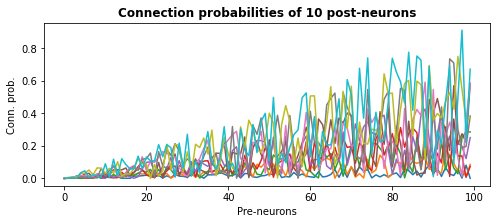

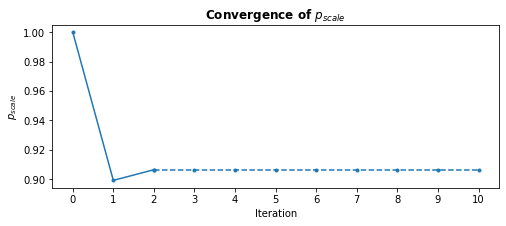

In [4]:
# Plot conn. prob.
plt.figure(figsize=(8, 3))
plt.plot(p)
plt.xlabel('Pre-neurons')
plt.ylabel('Conn. prob.')
plt.title(f'Connection probabilities of {M} post-neurons', fontweight='bold')
plt.savefig('check_conv_prob.png', dpi=300)
plt.show()

# ... and p_scale convergence
plt.figure(figsize=(8, 3))
plt.plot(np.arange(conv_idx + 1), [np.prod(p_scale_steps[:i + 1]) for i in range(conv_idx + 1)], '.-', color='tab:blue')
plt.plot(np.arange(conv_idx, len(p_scale_steps)), [np.prod(p_scale_steps[:i + 1]) for i in range(conv_idx, len(p_scale_steps))], '.--', color='tab:blue')
plt.xticks(np.arange(len(p_scale_steps)))
plt.xlabel('Iteration')
plt.ylabel('$p_{scale}$')
plt.title('Convergence of $p_{scale}$', fontweight='bold')
plt.savefig('check_conv.png', dpi=300)
plt.show()


## Step 2: Matching an instance to the mean

ℹ️ `opt_nconn` flag for rewiring operation

In [5]:
# Initialize connection probabilities
N = 100 # Number of pre-neurons

np.random.seed(0)
p = np.random.rand(N) * np.arange(N) / N # Connection probabilities for N pre-neurons
nconns_avg = np.round(np.sum(p)).astype(int)

In [6]:
# Draw connections K times w/o optimization
K = 1000
def draw_conns(p):
    return np.random.rand(len(p)) < p

conns = np.array([draw_conns(p) for k in range(K)])
p_conns = np.sum(conns, 0) / K

In [7]:
# Draw connections K times with optimization
OPT_NCONN_MAX_ITER = 1000
def draw_conns_opt(p):
    nconns_avg = np.round(np.sum(p)).astype(int) # Number of connections on average (=target count)
    nconns = -np.inf
    for n_opt in range(OPT_NCONN_MAX_ITER):
        conns_tmp = draw_conns(p)
        if np.abs(np.sum(conns_tmp) - nconns_avg) < np.abs(nconns - nconns_avg): # Keep closest value among all tries
            conns = conns_tmp
            nconns = np.sum(conns)
        if nconns == nconns_avg:
            break # Optimum found
    return conns

conns_opt = np.array([draw_conns_opt(p) for k in range(K)])
p_conns_opt = np.sum(conns_opt, 0) / K

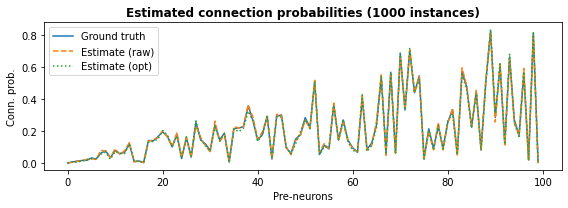

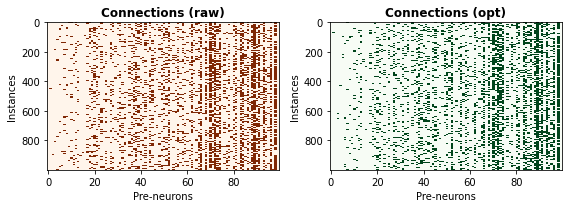

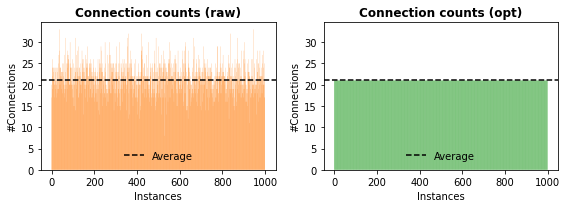

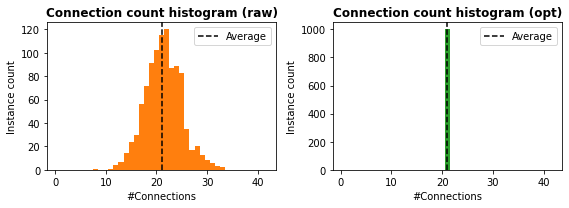

In [8]:
# Plot connection probabilities
plt.figure(figsize=(8, 3))
plt.plot(p, color='tab:blue', label='Ground truth')
plt.plot(p_conns, '--', color='tab:orange', label='Estimate (raw)')
plt.plot(p_conns_opt, ':', color='tab:green', label='Estimate (opt)')
plt.xlabel('Pre-neurons')
plt.ylabel('Conn. prob.')
plt.title(f'Estimated connection probabilities ({K} instances)', fontweight='bold')
plt.legend()
plt.tight_layout()
plt.savefig('check_opt_nconn_prob.png', dpi=300)
plt.show()

# ... and actual connections
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.imshow(conns, interpolation='nearest', cmap=plt.cm.Oranges)
plt.axis('tight')
plt.xlabel('Pre-neurons')
plt.ylabel('Instances')
plt.title('Connections (raw)', fontweight='bold')

plt.subplot(1, 2, 2)
plt.imshow(conns_opt, interpolation='nearest', cmap=plt.cm.Greens)
plt.axis('tight')
plt.xlabel('Pre-neurons')
plt.ylabel('Instances')
plt.title('Connections (opt)', fontweight='bold')
plt.tight_layout()
plt.savefig('check_opt_nconn_conns.png', dpi=300)
plt.show()

# ... and connection counts
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.bar(np.arange(conns.shape[0]), np.sum(conns, 1), align='edge', snap=False, color='tab:orange')
plt.xlim(plt.xlim())
ylim = plt.ylim()
plt.plot(plt.xlim(), np.full(2, nconns_avg), 'k--', label='Average')
plt.xlabel('Instances')
plt.ylabel('#Connections')
plt.title('Connection counts (raw)', fontweight='bold')
plt.legend(loc='lower center', frameon=False)

plt.subplot(1, 2, 2)
plt.bar(np.arange(conns_opt.shape[0]), np.sum(conns_opt, 1), align='edge', snap=False, color='tab:green')
plt.xlim(plt.xlim())
plt.plot(plt.xlim(), np.full(2, nconns_avg), 'k--', label='Average')
plt.ylim(ylim)
plt.xlabel('Instances')
plt.ylabel('#Connections')
plt.title('Connection counts (opt)', fontweight='bold')
plt.legend(loc='lower center', frameon=False)
plt.tight_layout()
plt.savefig('check_opt_nconn_count.png', dpi=300)
plt.show()

# ... and #connection histograms
cnt_bins = np.arange(0.5, 2 * nconns_avg + 0.5, 1)
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.hist(np.sum(conns, 1), cnt_bins, color='tab:orange')
plt.ylim(plt.ylim())
plt.plot(np.full(2, nconns_avg), plt.ylim(), 'k--', label='Average')
plt.xlabel('#Connections')
plt.ylabel('Instance count')
plt.title('Connection count histogram (raw)', fontweight='bold')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(np.sum(conns_opt, 1), cnt_bins, color='tab:green')
plt.ylim(plt.ylim())
plt.plot(np.full(2, nconns_avg), plt.ylim(), 'k--', label='Average')
plt.xlabel('#Connections')
plt.ylabel('Instance count')
plt.title('Connection count histogram (opt)', fontweight='bold')
plt.legend()
plt.tight_layout()
plt.savefig('check_opt_nconn_hist.png', dpi=300)
plt.show()